In [1]:
import pandas as pd
import numpy as np
from numpy import random

import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

import tree
import simulation as sim
import sim_utils as sut
import count_model as cmod
import tree_utils as tu

In [3]:
from comparison_functions import *

In [4]:
rseed = 42
np.random.seed(rseed)

In [36]:
real_name = "zebrafish"
real_cells = pd.read_csv("/home/npapado/Documents/data/schier_zebrafish/all_cols.txt",
                         sep=" ", header=0, index_col=0)
real_genes = pd.read_csv("/home/npapado/Documents/data/schier_zebrafish/all_rows.txt",
                         sep=" ", header=0, index_col=0)

del real_cells[real_cells.columns.values[-1]]
del real_genes[real_genes.columns.values[-1]]
real_stats = [real_cells, real_genes.loc[:, real_genes.loc['means'] > 0]]

In [7]:
top = tree.Tree.gen_random_topology(3)

branches = np.unique(np.array(top).flatten())
time = {b: 50 for b in branches}
G = np.sum((real_genes.loc['means'] > 0) & (real_genes.loc['var'] > 0))
t = tree.Tree(topology=top, G=G, time=time, num_branches=len(branches), branch_points=3, modules=50)

uMs, Ws, Hs = sim.simulate_lineage(t, intra_branch_tol=-1, inter_branch_tol=0, rel_exp_cutoff=50)

/home/npapado/Documents/repos/prosstt/dev/simulation.py:154: UserWarning: No argument 'a' specified in kwargs: using gamma and a=0.04
  "No argument 'a' specified in kwargs: using gamma and a=0.04", UserWarning)
/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


learn summary statistics and set simulation parameters accordingly

In [8]:
scale_params, alpha_mean, beta_mean, proposed_means = sut.learn_data_summary(real_cells, real_genes, uMs)
t.add_genes(uMs, np.array(proposed_means))
scale_mean, scale_var = scale_params

In [9]:
# use default variance for hyperparameter sampling
alpha_var = np.log(1.5)
beta_var = np.log(1.5)

alpha = np.exp(random.normal(loc=alpha_mean, scale=alpha_var, size=t.G))
beta = np.exp(random.normal(loc=beta_mean, scale=beta_var, size=t.G)) + 1
X, labs, brns, scalings = sim.sample_density(t, 10000, alpha=alpha, beta=beta,
                                             scale=True, scale_mean=scale_mean, scale_v=scale_var)

In [10]:
# calculate summary statistics
sim_means = np.mean(X, axis=0)
sim_vars = np.var(X, axis=0)
sim_zeros_gene = np.sum(X==0, axis=0)
sim_zeros_cell = np.sum(X==0, axis=1)
sim_totals = np.sum(X, axis=1)

sim_means[sim_means<=0] = 1e-4
sim_vars[sim_vars<=0] = 1e-4

simulated = [sim_means, sim_vars, sim_zeros_gene, sim_zeros_cell, sim_totals]

/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


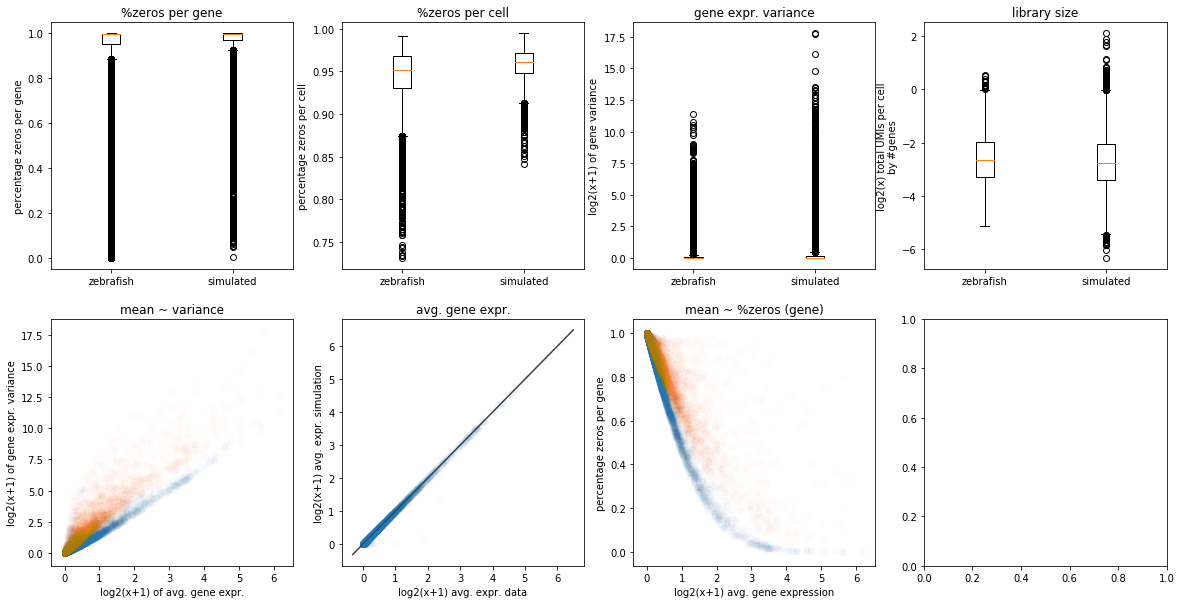

In [37]:
plot(real_name, real_stats, simulated, alpha=0.01)